In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = 15, 6
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%run period.py 128 2 0.25 --model_type gru --sigma 0.5 --sim_type period/uneven/noise0.5 --uneven --no_train --lr 5e-4
pred_gru = model.predict(X[test])
np.mean((pred_gru[:, 0:1] - Y[test, 0:1]) ** 2)

Using TensorFlow backend.


[]
/Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period/uneven/noise0.5/gru_128_x2_5m04_drop25
Loading /Users/brettnaul/Dropbox/Documents/timeflow/keras_logs/period/uneven/noise0.5/gru_128_x2_5m04_drop25/weights.h5...


0.018903830253113443

In [3]:
#%run period.py 64 2 0.25 --model_type gru --sigma 1 --sim_type period_only/even/noise1 --even
#pred_gru = model.predict(X[test])
#np.mean((pred_gru[:, 0:1] - Y[test, 0:1]) ** 2)

In [32]:
%debug

> /Users/brettnaul/miniconda3/envs/deep/lib/python3.5/site-packages/numpy/core/_methods.py(29)_amin()
     27 
     28 def _amin(a, axis=None, out=None, keepdims=False):
---> 29     return umr_minimum(a, axis, None, out, keepdims)
     30 
     31 def _sum(a, axis=None, dtype=None, out=None, keepdims=False):

ipdb> up
> /Users/brettnaul/Dropbox/Documents/gatspy/gatspy/periodic/optimizer.py(112)find_best_periods()
    110 
    111         # find initial candidates of unique peaks
--> 112         minscore = score.min()
    113         n_candidates = max(5, 2 * n_periods)
    114         candidate_freqs = np.zeros(n_candidates)

ipdb> score
array([], dtype=float64)
ipdb> up
> /Users/brettnaul/Dropbox/Documents/gatspy/gatspy/periodic/optimizer.py(14)best_period()
     12     def best_period(self, model):
     13         periods = self.find_best_periods(model, n_periods=1,
---> 14                                          return_scores=False)
     15         return periods[0]
     16 

--Key

In [62]:
%%time
from gatspy.periodic import LombScargle, LombScargleFast

pred_gat = np.zeros(pred_gru.shape)
for i in range(args.N_test):
    if args.even:
        t = np.linspace(0, 2 * np.pi, args.n_max)
        x = X[test[i]][:, 0]
    else:
        t = np.cumsum(X[test[i], :, 0])
        x = X[test[i], :, 1]
    opt_args = {'period_range': (0.05, 0.95 * (t.max() - t.min())), 'quiet': True}
    model_gat = LombScargle(fit_period=True, optimizer_kwds=opt_args)#, silence_warnings=True)
    model_gat.fit(t, x)
    omega = 2 * np.pi / model_gat.best_period
    off, A2, A1 = model_gat._best_params(omega)
#    pred_gat[i] = np.array([model_gat.best_period, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gat.ymean_])
    pred_gat[i] = np.array([model_gat.best_period, A1, A2, off + model_gat.ymean_])

CPU times: user 2min 39s, sys: 904 ms, total: 2min 40s
Wall time: 2min 41s


In [63]:
i = -1

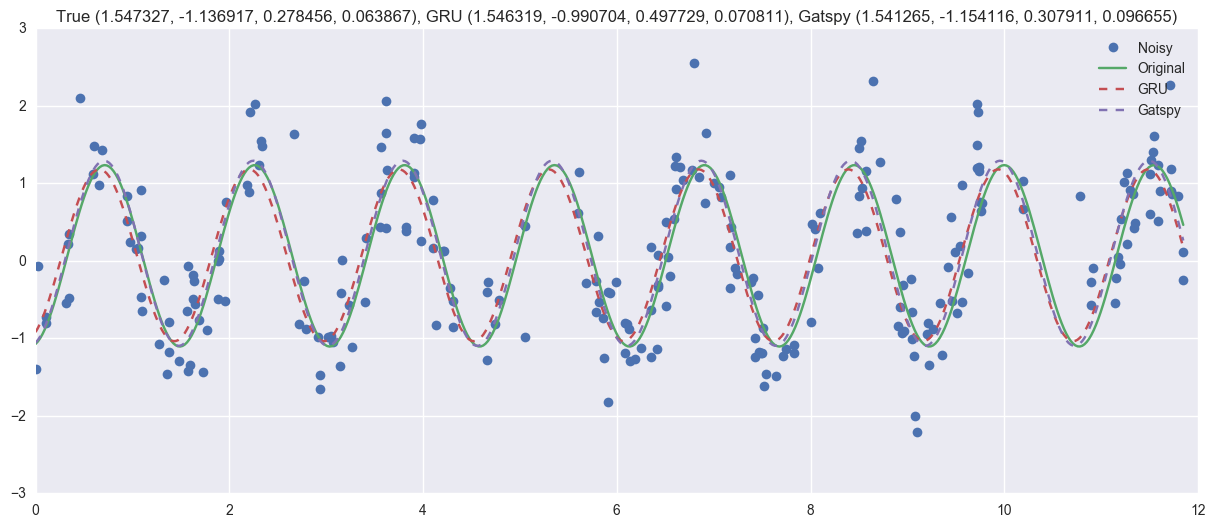

In [79]:
i += 1
if args.even:
    t = np.linspace(0, 2 * np.pi, args.n_max)
    x = X[test[i]].ravel()
else:
    t = X[test[i], :, 0].cumsum()
    x = X[test[i], :, 1]
plt.plot(t, x, 'o')

T = np.linspace(0, t.max(), 501)
def sinusoid(p, A1, A2, b):
    return lambda t: A1 * np.cos(2 * np.pi / p * t) + A2 * np.sin(2 * np.pi / p * t) + b

original = sinusoid(*Y[test[i]])
plt.plot(T, original(T), '-')

#p_c, A_c, phi_c, b_c = pred_conv[i]
#x_c = A_c * np.sin(2 * np.pi / p_c * t + phi_c) + b_c
#plt.plot(t, x_c, '--')

rnn = sinusoid(*pred_gru[i])
plt.plot(T, rnn(T), '--')

#omega = 2 * np.pi / model_gat.best_period
#off, A1, A2 = model_gat._best_params(omega)
#w_g, A_g, phi_g, b_g = [omega / 2 / np.pi, np.sqrt(A1 ** 2 + A2 ** 2), np.arctan2(A2, A1), off + model_gat.ymean_]
gat = sinusoid(*pred_gat[i])
plt.plot(T, gat(T), '--')

#plt.legend(['Noisy', 'Original', 'Convolutional', 'GRU', 'Gatspy'])
#plt.title("True ({:3f}, {:3f}, {:3f}, {:3f}), Conv ({:3f}, {:3f}, {:3f}, {:3f}), GRU ({:3f}, {:3f}, {:3f}, {:3f}), Gatspy ({:3f}, {:3f}, {:3f}, {:3f})".format(
#    p, A, phi, b,
#    p_c, A_c, phi_c, b_c,
#    p_r, A_r, phi_r, b_r,
#    p_g, A_g, phi_g, b_g,
#    ))
plt.legend(['Noisy', 'Original', 'GRU', 'Gatspy'])
plt.title("True ({:3f}, {:3f}, {:3f}, {:3f}), GRU ({:3f}, {:3f}, {:3f}, {:3f}), Gatspy ({:3f}, {:3f}, {:3f}, {:3f})".format(
    *Y[test[i]],
    *pred_gru[i],
    *pred_gat[i]
    ));

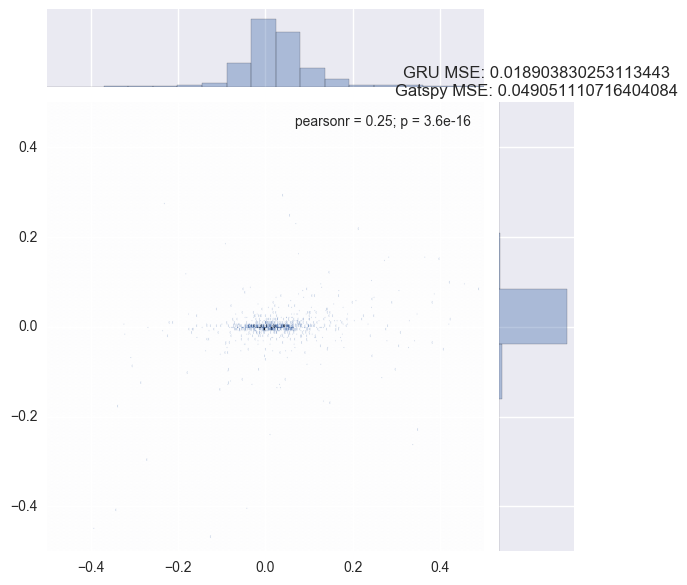

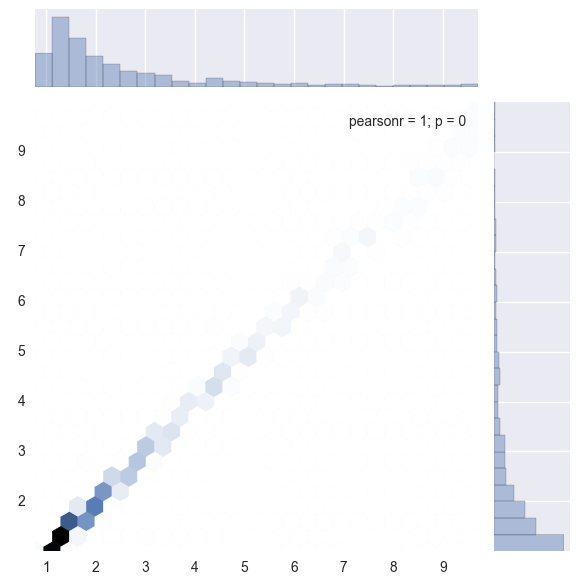

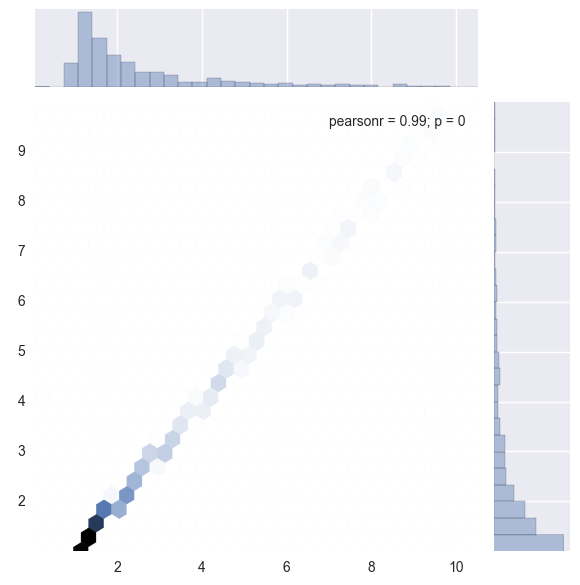

In [82]:
sns.jointplot(pred_gru[:, 0] - Y[test, 0], pred_gat[:, 0] - Y[test, 0], kind='hex', xlim=(-.5, .5), ylim=(-.5, .5))
plt.title("GRU MSE: {}\nGatspy MSE: {}".format(np.mean((pred_gru[:, 0] - Y[test, 0]) ** 2), np.mean((pred_gat[:, 0] - Y[test, 0]) ** 2)))
#plt.title("GRU MAE: {}\nGatspy MAE: {}".format(np.median(np.abs(pred_gru[:, 0] - Y[test, 0])), np.median(np.abs(pred_gat[:, 0] - Y[test, 0]))))
sns.jointplot(pred_gru[:, 0], Y[test, 0], kind='hex')
sns.jointplot(pred_gat[:, 0], Y[test, 0], kind='hex')

In [95]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

i = 0
input_img = Input(shape=(1, 28, 28))
print("{}: {}".format(i, tuple(int(x_i) for x_i in input_img.get_shape()[1:]))); i += 1
x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = MaxPooling2D((2, 2), border_mode='same')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = MaxPooling2D((2, 2), border_mode='same')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
encoded = MaxPooling2D((2, 2), border_mode='same')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in encoded.get_shape()[1:]))); i += 1

# at this point the representation is (8, 4, 4) i.e. 128-dimensional

x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = UpSampling2D((2, 2))(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = UpSampling2D((2, 2))(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = Convolution2D(16, 3, 3, activation='relu')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
x = UpSampling2D((2, 2))(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in x.get_shape()[1:]))); i += 1
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)
print("{}: {}".format(i, tuple(int(x_i) for x_i in decoded.get_shape()[1:]))); i += 1

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


0: (1, 28, 28)
1: (16, 28, 28)
2: (16, 14, 14)
3: (8, 14, 14)
4: (8, 7, 7)
5: (8, 7, 7)
6: (8, 4, 4)
7: (8, 4, 4)
8: (8, 8, 8)
9: (8, 8, 8)
10: (8, 16, 16)
11: (16, 14, 14)
12: (16, 28, 28)
13: (1, 28, 28)
